In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-to-german/_about.txt
/kaggle/input/english-to-german/deu.txt


In [2]:
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, TimeDistributed, Concatenate, RepeatVector, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
from tensorflow.keras import backend as K
logger = tf.get_logger()
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [3]:
plt.rcParams['figure.figsize'] = (12,8)

In [4]:
df = pd.read_csv('../input/english-to-german/deu.txt',delimiter='\t',header=None)
df.columns = ['English','German','Source']
df.head()

,English,German,Source
0,Go.,Geh.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Hallo!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Grüß Gott!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Run!,Lauf!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run.,Lauf!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [5]:
df.drop('Source',axis=1,inplace=True)

In [6]:
df.shape

(221533, 2)

In [7]:
df.isna().sum()

English    0
German     0
dtype: int64

In [8]:
df.duplicated().sum()

0

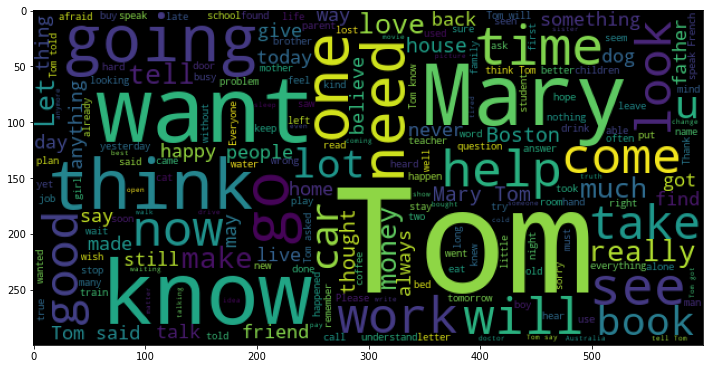

In [9]:
wc = WordCloud(width=600,height=300).generate(' '.join(df.English))
plt.imshow(wc);

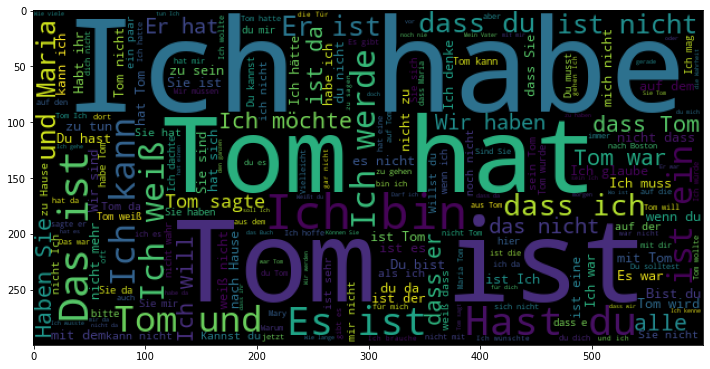

In [10]:
wc = WordCloud(width=600,height=300).generate(' '.join(df.German))
plt.imshow(wc);

In [11]:
df['eng_len'] = df.English.apply(len)
df['ger_len'] = df.German.apply(len)

<AxesSubplot:xlabel='ger_len', ylabel='Density'>

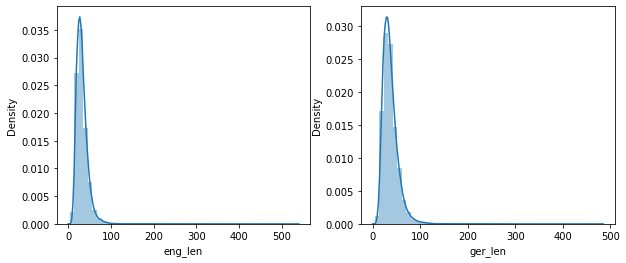

In [12]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
sns.distplot(df.eng_len,ax=axes[0])
sns.distplot(df.ger_len,ax=axes[1])

In [13]:
df.describe()

,eng_len,ger_len
count,221533.000000,221533.000000
mean,31.719974,37.005629
std,13.111863,15.787624
min,3.000000,4.000000
25%,23.000000,26.000000
50%,29.000000,34.000000
75%,38.000000,45.000000
max,537.000000,481.000000


In [14]:
max_eng_len = 40
max_ger_len = 40

In [15]:
def clean_text(text):
    text = text.lower()  
    pattern = re.compile('\W')
    text = re.sub(pattern,' ',text).strip()
    return text

In [16]:
df.English = df.English.progress_apply(clean_text)
df.German = df.German.progress_apply(clean_text)

  0%|          | 0/221533 [00:00<?, ?it/s]

  0%|          | 0/221533 [00:00<?, ?it/s]

In [17]:
df.German = df.German.apply(lambda x: '<START> ' + x + ' <END>')

In [18]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df.English)

In [19]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_vocab_size

15928

In [20]:
eng_sequences = eng_tokenizer.texts_to_sequences(df.English)
eng_pad_sequences = pad_sequences(eng_sequences,maxlen=max_eng_len,dtype='int32',padding='post',truncating='post')

In [21]:
ger_tokenizer = Tokenizer()
ger_tokenizer.fit_on_texts(df.German)

In [22]:
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_vocab_size

35055

In [23]:
ger_sequences = ger_tokenizer.texts_to_sequences(df.German)
ger_pad_sequences = pad_sequences(ger_sequences,maxlen=max_ger_len,dtype='int32',padding='post',truncating='post')

In [24]:
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [25]:
K.clear_session()

latent_dim = 300 
embedding_dim = 100 

encoder_inputs = Input(shape=(max_eng_len,))
encoder_emb = Embedding(eng_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_output2)
encoder_states = [state_h,state_c]

decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(ger_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_emb, initial_state=encoder_states) 

attn_layer = AttentionLayer(name='attention_layer') 
attn_outputs, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_outputs = Concatenate(axis=-1,name='concat_layer')([decoder_outputs, attn_outputs])

decoder_dense = TimeDistributed(Dense(ger_vocab_size,activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

2022-10-28 21:39:36.660672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 21:39:36.661661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 21:39:37.097446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 21:39:37.098777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 21:39:37.099964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      1592800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

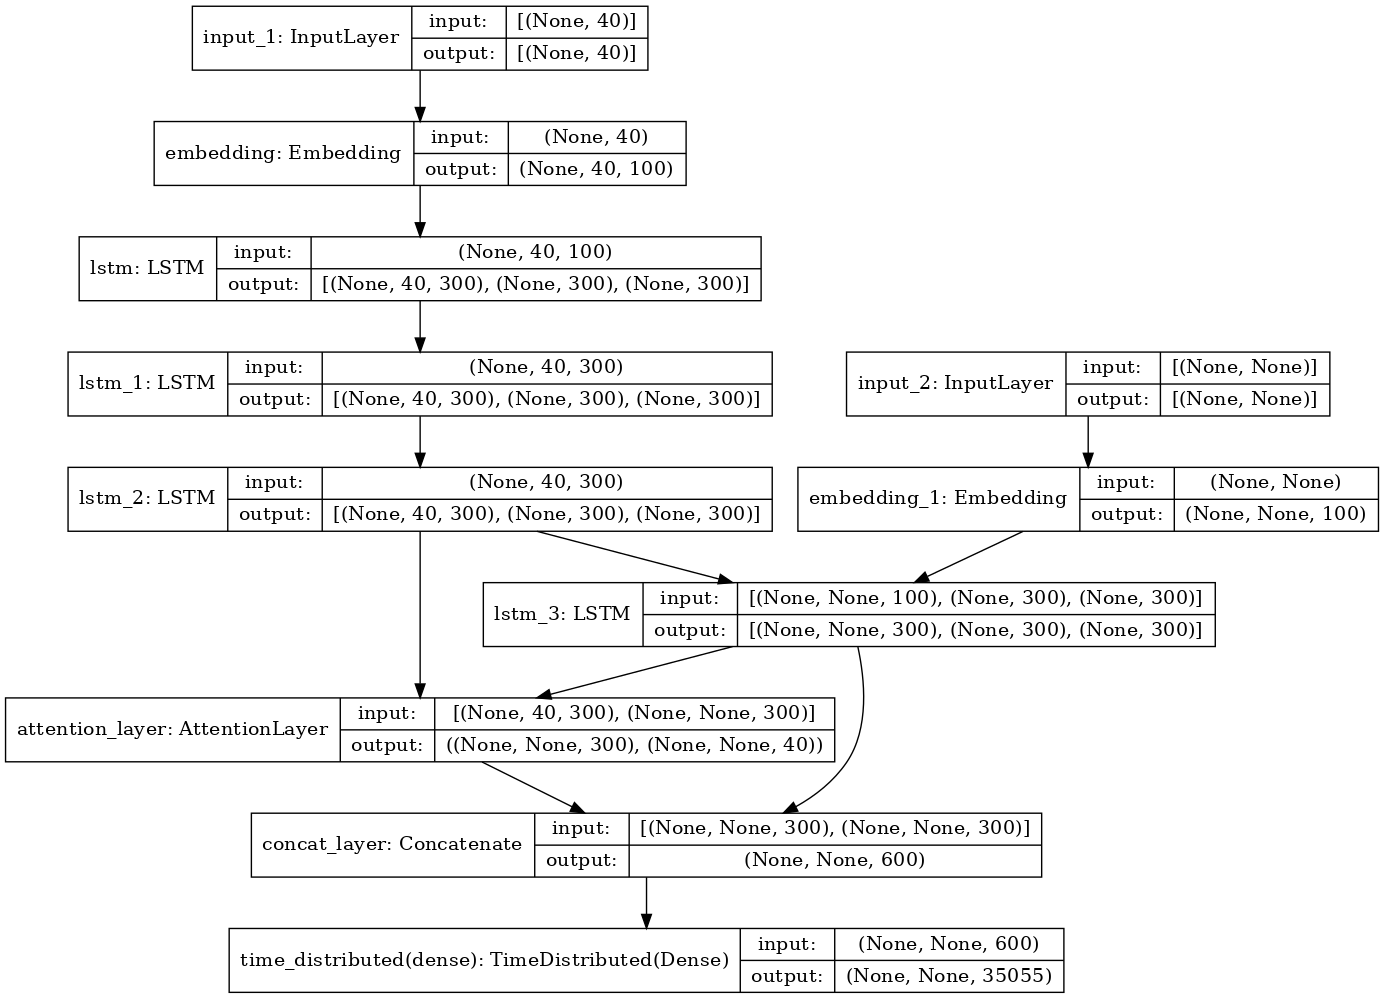

In [26]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

In [27]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

In [28]:
 X_train, X_test, y_train, y_test = train_test_split(eng_pad_sequences,ger_pad_sequences,test_size=0.25,shuffle=True,random_state=101)

In [29]:
es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=40)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=5,factor=0.1,min_lr=0.001)
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

r = model.fit([X_train,y_train[:,:-1]],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1)[:,1:],
             epochs=50,
             batch_size=512,
             callbacks=[es,rl,mc],
             validation_data=([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

2022-10-28 21:39:46.707426: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
325/325 [==============================] - 862s 3s/step - loss: 1.2018 - accuracy: 0.8398 - val_loss: 0.9793 - val_accuracy: 0.8541

Epoch 00001: val_accuracy improved from -inf to 0.85415, saving model to checkpoint/


2022-10-28 21:54:13.194600: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
325/325 [==============================] - 848s 3s/step - loss: 0.8895 - accuracy: 0.8637 - val_loss: 0.8190 - val_accuracy: 0.8723

Epoch 00002: val_accuracy improved from 0.85415 to 0.87231, saving model to checkpoint/
Epoch 3/50
325/325 [==============================] - 846s 3s/step - loss: 0.7653 - accuracy: 0.8769 - val_loss: 0.7185 - val_accuracy: 0.8834

Epoch 00003: val_accuracy improved from 0.87231 to 0.88341, saving model to checkpoint/
Epoch 4/50
325/325 [==============================] - 841s 3s/step - loss: 0.6818 - accuracy: 0.8863 - val_loss: 0.6528 - val_accuracy: 0.8917

Epoch 00004: val_accuracy improved from 0.88341 to 0.89170, saving model to checkpoint/
Epoch 5/50
325/325 [==============================] - 840s 3s/step - loss: 0.6168 - accuracy: 0.8943 - val_loss: 0.6035 - val_accuracy: 0.8984

Epoch 00005: val_accuracy improved from 0.89170 to 0.89839, saving model to checkpoint/
Epoch 6/50
325/325 [==============================] - 840s 3s/step - los

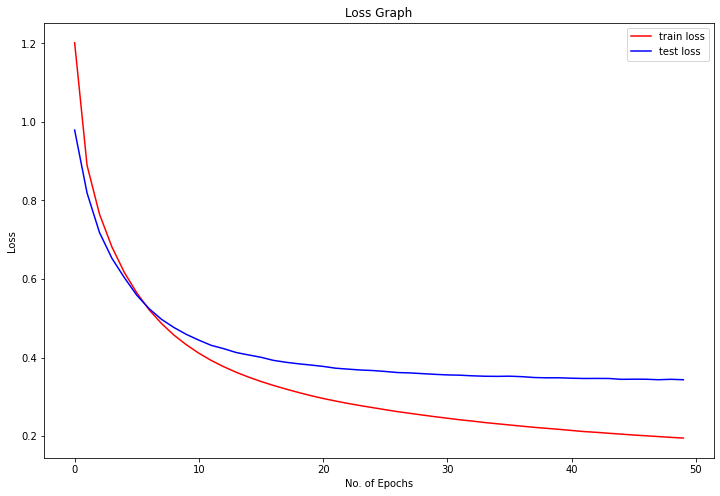

In [30]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

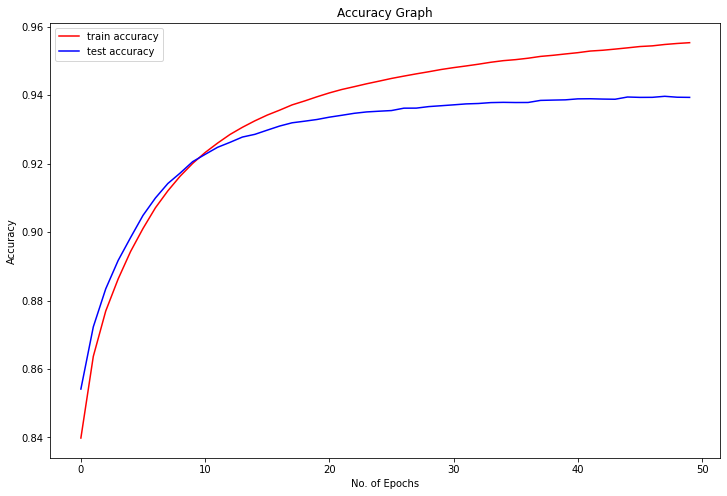

In [31]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [32]:
model.evaluate([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:])

1731/1731 [==============================] - 231s 133ms/step - loss: 0.3435 - accuracy: 0.9393


[0.34349894523620605, 0.9393266439437866]

In [33]:
model.save('english_to_german_translator.h5')
lm = load_model('english_to_german_translator.h5',custom_objects={'AttentionLayer': AttentionLayer})

In [34]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(max_eng_len, latent_dim))

decoder_out, decoder_state_a, decoder_state_c = decoder_lstm(decoder_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state, decoder_out])
decoder_inf_concat_outputs = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat_outputs)
decoder_model = Model([decoder_inputs]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_state_a, decoder_state_c])

In [35]:
def decode_sequences(input_sequence):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_sequence)
    next_input = np.zeros((1,1))
    next_input[0,0] = ger_tokenizer.word_index['start']
    output_sequence = ''
    flag = False
    while not flag:
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c])
        output_idx = np.argmax(decoded_out[0, -1, :])
        if output_idx == ger_tokenizer.word_index['end']: 
            flag = True
        elif output_idx > 0 and output_idx != ger_tokenizer.word_index['start']:
            output_token = ger_tokenizer.index_word[output_idx] 
            output_sequence = output_sequence + ' ' + output_token 
        next_input[0,0] = output_idx
        # Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c
        
    return output_sequence     

In [36]:
def sequence_to_language(input_sequence,tokenizer,lang):
    res = ''
    
    if lang == 'eng':
        for idx in input_sequence:
            if idx != 0:
                res = res + tokenizer.index_word[idx] + ' '
    
    elif lang == 'ger':
        for idx in input_sequence:
            if idx > 0:
                if tokenizer.index_word[idx] != 'start' and tokenizer.index_word[idx] != 'end':
                    res = res + tokenizer.index_word[idx] + ' '
                    
    return res

In [37]:
def predicted_sequence_to_ger_language(input_sequence):
    res = ''
    
    for idx in input_sequence:
        if idx > 0:
            if ger_tokenizer.index_word[idx] != 'start' and ger_tokenizer.index_word[idx] != 'end':
                res = res + ger_tokenizer.index_word[idx] + ' '
    
    return res

In [38]:
predicted_ger_translations= []

for i in range(20):
    print("English Sentence:",sequence_to_language(X_test[i],eng_tokenizer,'eng'))
    print("Original German Translation:",sequence_to_language(y_test[i],ger_tokenizer,'ger'))
    pred_german_sentence = decode_sequences(X_test[i].reshape(1,max_eng_len))
    print("Predicted German Translation:",pred_german_sentence)
    predicted_ger_translations.append(pred_german_sentence)

English Sentence: ten years have passed since i came to tokyo at the age of eighteen 
Original German Translation: zehn jahre ist es her seit ich mit achtzehn nach tokio kam 
Predicted German Translation:  zehn jahre her seit ich in dem leben nach dem leben nach dem leben gekommen sind
English Sentence: get me the newspaper 
Original German Translation: hol mir die zeitung 
Predicted German Translation:  bring mir die zeitung
English Sentence: bring an umbrella because it is expected to rain this afternoon 
Original German Translation: nimm einen schirm mit denn es ist für den nachmittag regen angesagt 
Predicted German Translation:  nehmen sie einen regenschirm aus dem ob es heute nachmittag regnen hat
English Sentence: i didn t hear you 
Original German Translation: ich habe euch nicht gehört 
Predicted German Translation:  ich habe euch nicht gehört
English Sentence: tom sprang to his feet 
Original German Translation: tom sprang auf 
Predicted German Translation:  tom sprang an sei

In [39]:
original_ger_translations = []
for i in range(20):
    original_ger_translations.append(sequence_to_language(y_test[i],ger_tokenizer,'ger'))
references = []

for trans in original_ger_translations:
    ref = trans.split()
    references.append(ref)

In [40]:
orig_ger_sents = []
smooth = SmoothingFunction().method4

for i in range(20):
    print("Original German Sentence:",references[i])
    print("Predicted German Sentence:",predicted_ger_translations[i])
    print("BLEU Score:",sentence_bleu(references[i],predicted_ger_translations[i],weights=(0.25,0.25,0.25,0.25)))

Original German Sentence: ['zehn', 'jahre', 'ist', 'es', 'her', 'seit', 'ich', 'mit', 'achtzehn', 'nach', 'tokio', 'kam']
Predicted German Sentence:  zehn jahre her seit ich in dem leben nach dem leben nach dem leben gekommen sind
BLEU Score: 0.13484017510794372
Original German Sentence: ['hol', 'mir', 'die', 'zeitung']
Predicted German Sentence:  bring mir die zeitung
BLEU Score: 0.35537192498941217
Original German Sentence: ['nimm', 'einen', 'schirm', 'mit', 'denn', 'es', 'ist', 'für', 'den', 'nachmittag', 'regen', 'angesagt']
Predicted German Sentence:  nehmen sie einen regenschirm aus dem ob es heute nachmittag regnen hat
BLEU Score: 0.2557674853622663
Original German Sentence: ['ich', 'habe', 'euch', 'nicht', 'gehört']
Predicted German Sentence:  ich habe euch nicht gehört
BLEU Score: 0.41862765131604623
Original German Sentence: ['tom', 'sprang', 'auf']
Predicted German Sentence:  tom sprang an seine füße
BLEU Score: 0.2425056620207466
Original German Sentence: ['wo', 'ist', 'ihr